<a href="https://colab.research.google.com/github/rahiakela/deep-learning-with-python-francois-chollet/blob/6-deep-learning-for-text-and-sequences/6_sequence_processing_with_convnets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence processing with convnets

You learned about convolutional neural networks (convnets) and how they perform particularly well on computer vision problems, due to their ability to operate convolutionally, extracting features from local input patches and allowing for
representation modularity and data efficiency. The same properties that make convnets excel at computer vision also make them highly relevant to sequence processing. Time can be treated as a spatial dimension, like the height or width of a 2D image.

Such 1D convnets can be competitive with RNNs on certain sequence-processing
problems, usually at a considerably cheaper computational cost. Recently, 1D convnets, typically used with dilated kernels, have been used with great success for audio generation and machine translation. In addition to these specific successes, it has long been known that small 1D convnets can offer a fast alternative to RNNs for simple tasks such as text classification and timeseries forecasting.

**Understanding 1D convolution for sequence data**

The convolution layers introduced previously were 2D convolutions, extracting 2D
patches from image tensors and applying an identical transformation to every patch. In the same way, you can use 1D convolutions, extracting local 1D patches (subsequences) from sequences.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/1D-convolution.png?raw=1' width='800'/>

Such 1D convolution layers can recognize local patterns in a sequence. Because the same input transformation is performed on every patch, a pattern learned at a certain position in a sentence can later be recognized at a different position, making 1D convnets translation invariant (for temporal translations). 

For instance, a 1D convnet processing sequences of characters using convolution windows of size 5 should be able to learn words or word fragments of length 5 or less, and it should be able to recognize these words in any context in an input sequence. A character-level 1D convnet is thus able to learn about word morphology.

**1D pooling for sequence data**

You’re already familiar with 2D pooling operations, such as 2D average pooling and max pooling, used in convnets to spatially downsample image tensors. The 2D pooling operation has a 1D equivalent: extracting 1D patches (subsequences) from an input and outputting the maximum value (max pooling) or average value (average pooling). Just as with 2D convnets, this is used for reducing the length of 1D inputs (subsampling).


## Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, LSTM, Embedding, GRU, Bidirectional
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.datasets import imdb

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import backend as K

import numpy as np
import pandas as pd

import string
import os

import matplotlib.pyplot as plt
%matplotlib inline

## Implementing a 1D convnet

n Keras, you would use a 1D convnet via the Conv1D layer, which has a very similar interface to Conv2D. It takes as input 3D tensors with shape (samples, time, features) and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal axis, axis 1 in the input tensor.

Let's build a simple 2-layer 1D convnet and apply it to the IMDB sentiment classification task that you are already familiar with.

As a reminder, this is the code for obtaining and preprocessing the data:

In [2]:
max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


1D convnets are structured in the same way as their 2D counter-parts: they consist of a stack of Conv1D and MaxPooling1D layers, eventually ending in either a global pooling layer or a Flatten layer, turning the 3D outputs into 2D outputs, allowing to add one or more Dense layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

This is our example 1D convnet for the IMDB dataset:

In [3]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=max_len))

model.add(Conv1D(32, 7, activation='relu'))
model.add(MaxPooling1D(5))

model.add(Conv1D(32, 7, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1))

model.summary()

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=100, batch_size=128, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

Here are our training and validation results: validation accuracy is somewhat lower than that of the LSTM we used two sections ago, but runtime is faster, both on CPU and GPU (albeit the exact speedup will vary greatly depending on your exact configuration). At that point, we could re-train this model for the right number of epochs (8), and run it on the test set. This is a convincing demonstration that a 1D convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task.

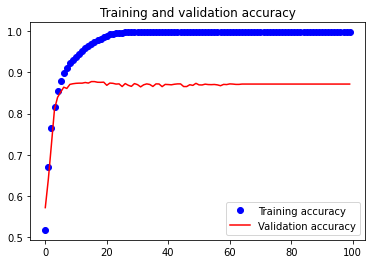

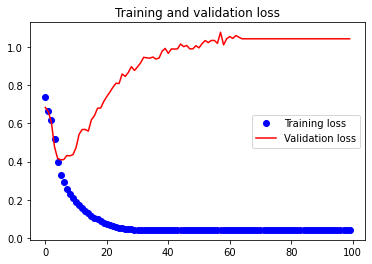

In [4]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Combining CNNs and RNNs to process long sequences

Because 1D convnets process input patches independently, they are not sensitive to the order of the timesteps (beyond a local scale, the size of the convolution windows), unlike RNNs. Of course, in order to be able to recognize longer-term patterns, one could stack many convolution layers and pooling layers, resulting in upper layers that would "see" long chunks of the original inputs -- but that's still a fairly weak way to induce order-sensitivity. One way to evidence this weakness is to try 1D convnets on the temperature forecasting problem from the previous section, where order-sensitivity was key to produce good predictions. Let's see:

In [5]:
# Download and uncompress the data
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2020-06-29 05:18:29--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.141.118
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.141.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13568290 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  6.46MB/s    in 2.0s    

2020-06-29 05:18:32 (6.46 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13568290/13568290]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  


In [6]:
# Inspecting the data of the Jena weather dataset
fname = 'jena_climate_2009_2016.csv'
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [7]:
# convert all 420,551 lines of data into a Numpy array.
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i, :] = values

In [8]:
#  compute the mean and standard deviation only on this fraction of the data
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

In [9]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
  if max_index is None:
    max_index = len(data) - delay - 1
  i = min_index + lookback
  while 1:
    if shuffle:
      rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
    else:
      if i + batch_size >= max_index:
        i = min_index + lookback
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
    
    samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
    targets = np.zeros((len(rows),))

    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [10]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

# This is how many steps to draw from `val_gen` in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen` in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [11]:
model = Sequential()

model.add(Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))

model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(3))

model.add(Conv1D(32, 5, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

Here are our training and validation Mean Absolute Errors:

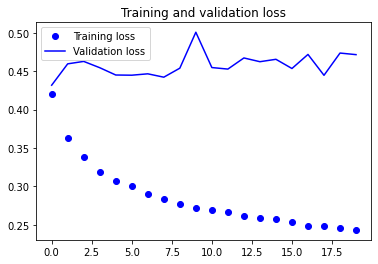

In [12]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The validation MAE stays in the low 0.40s: we cannot even beat our common-sense baseline using the small convnet. Again, this is because our convnet looks for patterns anywhere in the input timeseries, and has no knowledge of the temporal position of a pattern it sees (e.g. towards the beginning, towards the end, etc.). Since more recent datapoints should be interpreted differently from older datapoints in the case of this specific forecasting problem, the convnet fails at producing meaningful results here. This limitation of convnets was not an issue on IMDB, because patterns of keywords that are associated with a positive or a negative sentiment will be informative independently of where they are found in the input sentences.

One strategy to combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing step before a RNN. This is especially beneficial when dealing with sequences that are so long that they couldn't realistically be processed with RNNs, e.g. sequences with thousands of steps. The convnet will turn the long input sequence into much shorter (downsampled) sequences of higher-level features. This sequence of extracted features then becomes the input to the RNN part of the network.

<img src='https://github.com/rahiakela/img-repo/blob/master/deep-learning-with-python/convolution-rnn.png?raw=1' width='800'/>

This technique is not seen very often in research papers and practical applications, possibly because it is not very well known. It is very effective and ought to be more common. Let's try this out on the temperature forecasting dataset. Because this strategy allows us to manipulate much longer sequences, we could either look at data from further back (by increasing the lookback parameter of the data generator), or look at high-resolution timeseries (by decreasing the step parameter of the generator). Here, we will chose (somewhat arbitrarily) to use a step twice smaller, resulting in twice longer timeseries, where the weather data is being sampled at a rate of one point per 30 minutes.

In [13]:
# This was previously set to 6 (one point per hour).
# Now 3 (one point per 30 min).
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step)

val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

This is our model, starting with two Conv1D layers and following-up with a GRU layer:

In [14]:
model = Sequential()

model.add(Conv1D(32, 5, activation='relu', input_shape=(None, float_data.shape[-1])))
model.add(MaxPooling1D(3))

model.add(Conv1D(32, 5, activation='relu'))
model.add(GRU(32, dropout=0.1, recurrent_dropout=0.5))

model.add(Dense(1))

model.summary()

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
500/500 [==============================] - 218s 436ms/step - loss: 0.3262 - val_loss: 0.2875
Epoch 2/20
5

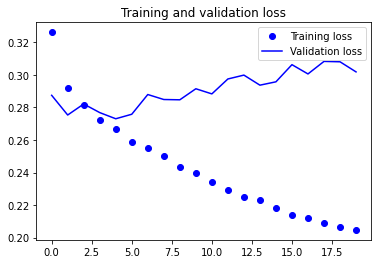

In [15]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Judging from the validation loss, this setup is not quite as good as the regularized GRU alone, but it's significantly faster. It is looking at twice more data, which in this case doesn't appear to be hugely helpful, but may be important for other datasets.

## Wrapping up

Here's what you should take away from this section:

* In the same way that 2D convnets perform well for processing visual patterns in 2D space, 1D convnets perform well for processing temporal patterns. They offer a faster alternative to RNNs on some problems, in particular NLP tasks.
* Typically 1D convnets are structured much like their 2D equivalents from the world of computer vision: they consist of stacks of Conv1D layers and MaxPooling1D layers, eventually ending in a global pooling operation or flattening operation.
* Because RNNs are extremely expensive for processing very long sequences, but 1D convnets are cheap, it can be a good idea to use a 1D convnet as a preprocessing step before a RNN, shortening the sequence and extracting useful representations for the RNN to process.

One useful and important concept that we will not cover in these pages is that of 1D convolution with dilated kernels.